In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
from mesh import *
from boundary import *
from hard_boundary import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx, ny = 50, 50
annulus = Analytical_Annulus(1., 0.6, 0.6)

In [3]:
tau = 12
n = 0.38
k = 1.77
dpdz = 15567.43

class Gov_Eq(Hard_Solve):
    
    def PDELoss(self, inputs, outputs):
        
        # sepearte the inputs
        xi, eta = inputs[:,0], inputs[:,1]
        
        
        # calculate the x and y coords
        grid = TFI(xi, eta, annulus)
        x,y = grid.X(), grid.Y()
        
        # calculate the grid gradients
        dxdxi, dxdeta, dydxi, dydeta, jac = self.cal_grads(x,y, xi, eta)
        
        # calculate the alpha, beta and gamma
        alpha = dxdeta**2 + dydeta**2
        gamma = dxdeta*dxdxi + dydeta*dydxi
        beta = dxdxi**2 + dydxi**2
        
        # output gradients
        out_grad = self.compute_grad(outputs, inputs)
        dudxi = out_grad[:,0]
        dudeta = out_grad[:,1]
        
        # calculate the modified apparent viscosity
        vis = self.HB_model(out_grad, x, y, xi, eta, n, k, tau)
        
        # calclate the left gov eq
        left = (vis/jac)*(alpha*dudxi - gamma*dudeta)
        
        # calculate the right side gov eq
        right = (vis/jac)*(beta*dudeta - gamma*dudxi)
        
        # derivative of left wrt xi
        dleft_dxi = self.compute_grad(left, inputs)[:,0]
        
        # derivative of right wrt eta
        dright_deta = self.compute_grad(right, inputs)[:,1]
        
        # combine governing equation
        gov_eq = dleft_dxi + dright_deta - jac*dpdz
        
        return {'PDE': gov_eq}
    
#     def HB_model(self, out_grad, x, y, xi, eta, n, k, tau):
#         shear = self.shear_rate(out_grad, x,y, xi, eta)
#         app_vis = (tau/shear) + (shear**(n-1))*k
#         return app_vis
    
    # define the modified apparent viscosity
    def HB_model(self, out_grad, x, y, xi, eta, n, k, tau, cs=0.1 ):
        
        # calculate the shear 
        shear = self.shear_rate(out_grad, x, y, xi, eta)
        
        # create a dummy vicosity
        vis = torch.zeros_like(shear)
        
        # mask the shear rate less than the crtial shear rate
        # mask for the body portion
        mask_body = shear>cs
        # mask for the boundary portion
        mask_bound = shear<= cs
        
        # create index for the body and boundary mask
        ind_body = torch.nonzero(mask_body).unsqueeze(1)
        ind_bound = torch.nonzero(mask_bound).unsqueeze(1)
        
        # calculate the modified apparent viscsity
        vis[ind_body] = (tau/cs) + ((shear[ind_body]/cs)**(n-1))*k
        #vis[ind_bound] = tau*(2 - (shear[ind_bound]/cs))/cs + k * ( (2-n)+(n-1)* (shear[ind_bound]/cs))
        vis[ind_bound] = tau*(2/cs) + k*(2-n)
        
        return vis
    
    # define the shear rate
    def shear_rate(self, out_grad, x,y, xi, eta, tol=1e-12):
        # calcuate the cord grads
        dxdxi, dxdeta, dydxi, dydeta, jac = self.cal_grads(x,y,xi, eta)
        
        # output grads
        dudxi = out_grad[:,0]
        dudeta = out_grad[:,1]
        
        # calculate the shear rate
        shear_ = (1/jac)*((dydeta*(dudxi) - dydxi*(dudeta))**2 + (dxdxi*(dudeta) - dxdeta*(dudxi))**2)**(0.5)
        
        # create mask
        dummy_shear = torch.zeros_like(shear_)
        mask = shear_ <=0
        indices = torch.nonzero(mask).unsqueeze(1)
        dummy_shear[indices] = tol
        shear = (1/jac)*((dydeta*(dudxi+dummy_shear) - dydxi*(dudeta+dummy_shear))**2 + (dxdxi*(dudeta+dummy_shear) - dxdeta*(dudxi+dummy_shear))**2)**(0.5)
        
        return torch.abs_(shear)
    
    def cal_grads(self, x, y, xi, eta):
        # compute all the gradients wrt x,y 
        dxdxi = self.compute_grad(x, xi)
        dxdeta = self.compute_grad(x, eta)
        dydxi = self.compute_grad(y, xi)
        dydeta = self.compute_grad(y, eta)
        jac = dxdxi*dydeta - dxdeta*dydxi

        return dxdxi, dxdeta, dydxi, dydeta, jac
    
# initialize the PDE governing equations
pde = Gov_Eq(inputs=('xi', 'eta'), outputs=('u'))

In [4]:
# define the mesh
xi_m, eta_m = np.linspace(0,1,nx), np.linspace(0,1,ny)
mesh = Hard_Mesh({'xi':xi_m, 'eta': eta_m})
pde.set_mesh(mesh)

In [5]:
lr = 1e-3
epochs = 2000
hid_dim = 100
layers = 4
in_dim = len(pde.inputs)
out_dim = len(pde.outputs)
#activation = Sine()
activation = torch.nn.Tanh()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
#net.apply(_init_weights)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(net,optimizer, scheduler)

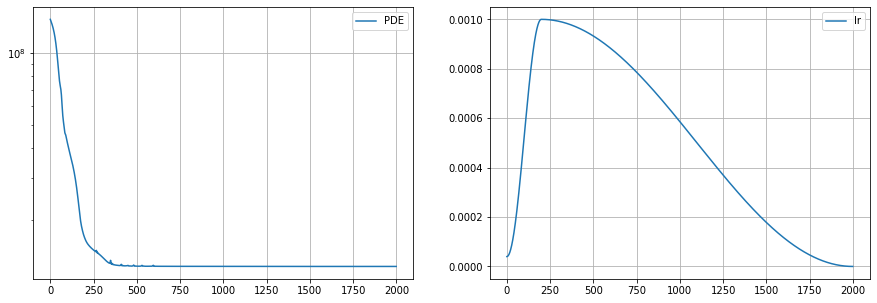

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 14min 11s


In [6]:
%time hist = pde.hard_solve(nx, ny, epochs)

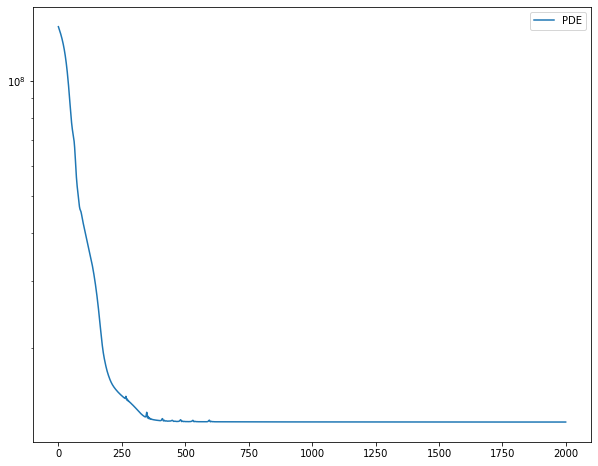

In [7]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [8]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)

eval_mesh = Hard_Mesh({'x':x, 'y':y})
pred = pde.eval(eval_mesh).view(nx,ny).numpy()
#vel_x, vel_y = pde.axial_velocity(eval_mesh)

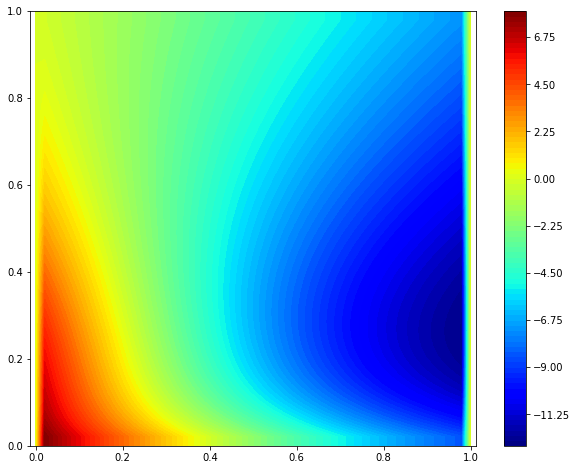

In [9]:
plt.figure(figsize=(10,8))
xx, yy = np.meshgrid(x,y)
plt.contourf(xx,yy, pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

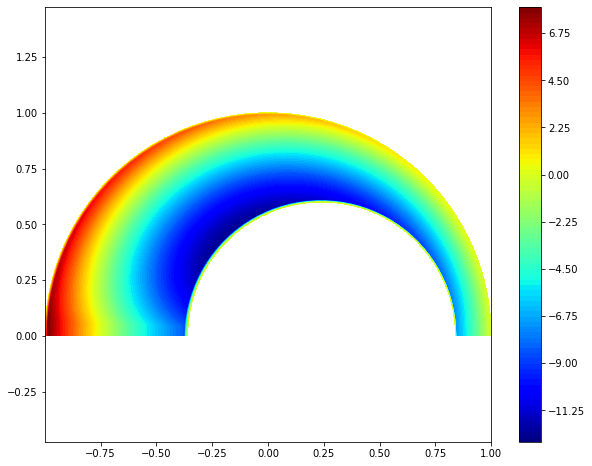

In [10]:
plt.figure(figsize=(10,8))
grid = TFI(torch.from_numpy(xx), torch.from_numpy(yy), annulus)
plt.contourf(grid.X().detach().numpy().reshape(nx,ny),grid.Y().detach().numpy().reshape(nx,ny), pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

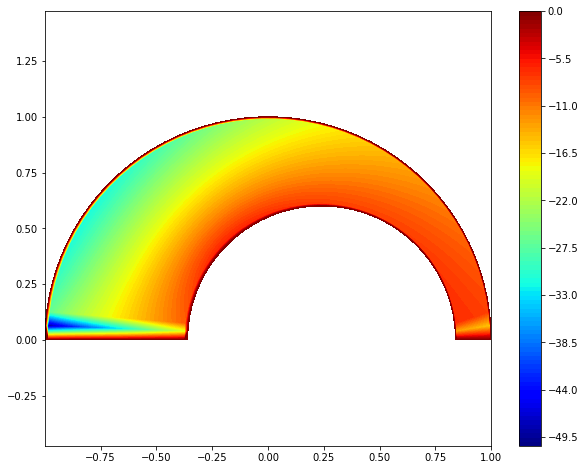

In [11]:
vel_x, vel_y = pde.axial_velocity(eval_mesh)
vel_x = vel_x.reshape(nx,ny).detach().numpy()
plt.figure(figsize=(10,8))
grid = TFI(torch.from_numpy(xx), torch.from_numpy(yy), annulus)
plt.contourf(grid.X().detach().numpy().reshape(nx,ny),grid.Y().detach().numpy().reshape(nx,ny), vel_x, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

In [12]:
test1 = Hard_Mesh({'x':xi_m, 'y':eta_m}).data()[:,0].reshape(-1,1)
test2 = Hard_Mesh({'x':xi_m, 'y':eta_m}).data()[:,1].reshape(-1,1)

In [13]:
torch.cat((test2,test1), dim=1)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0204],
        [0.0000, 0.0408],
        ...,
        [1.0000, 0.9592],
        [1.0000, 0.9796],
        [1.0000, 1.0000]])

In [9]:
torch.sqrt(torch.Tensor([1e-5])**2)

tensor([1.0000e-05])

In [8]:
torch.Tensor([1e-5])**

SyntaxError: invalid syntax (<ipython-input-8-f67538728dc8>, line 1)